In [3]:
import numpy as np
import pandas as pd
from numba import njit, jit

from math import log, sqrt, pi, exp, erf, ceil, floor
from scipy.stats import norm

from matplotlib import pyplot as plt
from tqdm import tqdm, trange
from time import perf_counter
import gc

""" Plt font size """
plt.rcParams['font.size'] = '13'

Time per 10,000 samples = 3.09 sec

# Part 1

In [4]:
""" Euler's Method """
def gbm_euler(S0, r, sigma, T, M, path_simulation=False):
    zm = norm.rvs(loc=0., scale=1, size=M)
    dt = T / M
    Sm = np.zeros((M+1, 2), dtype=float)   ;   Sm[0, 0] = S0
    for m in range(1, M+1):
        Sm[m, 0] = Sm[m-1, 0] + r*Sm[m-1, 0]*dt + sigma*Sm[m-1, 0]*sqrt(dt)*zm[m-1]
        Sm[m, 1] = m * dt
    if path_simulation:
        return Sm
    return Sm[-1,0]

<AxesSubplot:title={'center':'Simulated Stock Movement Using Geometric Brownian Motion'}, xlabel='Time', ylabel='Stock Price'>

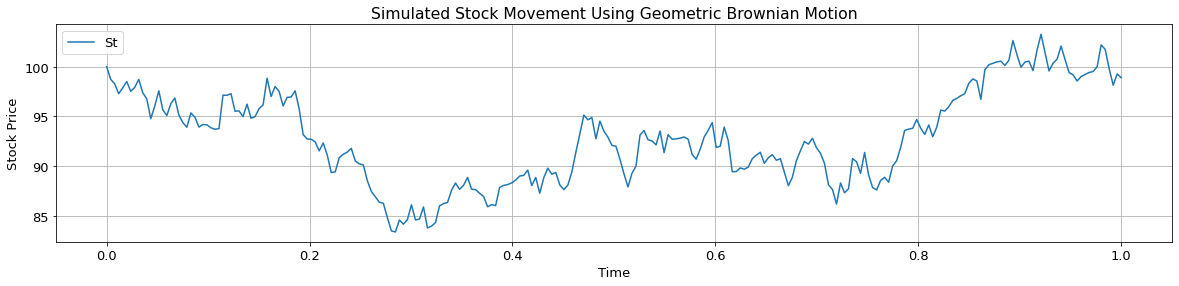

In [179]:
""" Geometric Brownian Motion - St Simulation"""
S0 = 100
sigma = .20
r = 0.06
T = 1.
M = 253
output = gbm_euler(S0, r, sigma, T, M, path_simulation=True)

temp_output = pd.DataFrame(output, columns=['St', 'Time'])
temp_output = temp_output.set_index('Time')
temp_output.plot(figsize=(20,4), grid=True, title="Simulated Stock Movement Using Geometric Brownian Motion", ylabel="Stock Price", label=f'Euler Method M={M}')

----------------------------------------------------------------------------------------------------------------------------------------------------------------
## Payoff Distribution and Convergence for Different Number of Paths (M)

100%|██████████| 100000/100000 [00:20<00:00, 4913.50it/s]


Probability of tbe option expiring in the Money = 40.16000 %
Expected Payoff = 4.79460 EUR 
Standard Deviation of E(Payoff) = 8.48866 EUR


Text(0.5, 0, 'Payoff of Put Option (EUR)')

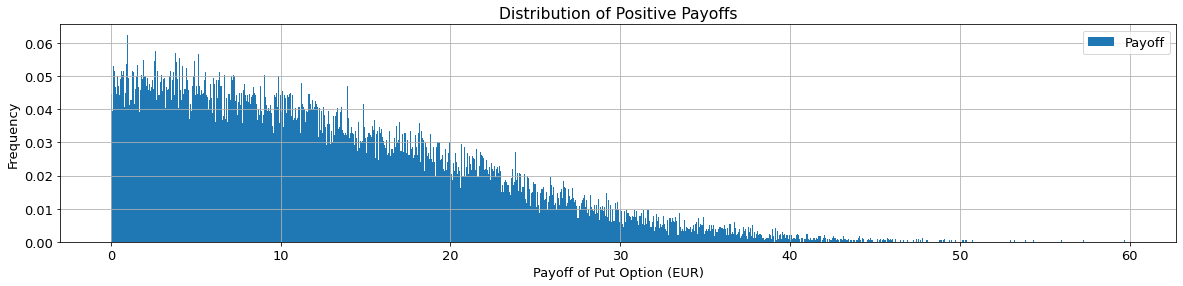

In [182]:
simulations = 100_000
payoff_dist = np.empty(simulations)
for inx in trange(simulations):
    K = 99 ; N = 254
    payoff_dist[inx] = max(K- gbm_euler(S0, r, sigma, T, N), 0)

print(f'Probability of tbe option expiring in the Money = {payoff_dist[payoff_dist > 0].shape[0] / simulations *100:.5f} %')
print(f'Expected Payoff = {payoff_dist.mean()*np.exp(-r*T):.5f} EUR \nStandard Deviation of E(Payoff) = {payoff_dist.std():.5f} EUR')
ax = pd.DataFrame(payoff_dist[payoff_dist>0], columns=['Payoff']).plot(kind='hist', bins=1000, density=True, figsize=(20,4), grid=True, title="Distribution of Positive Payoffs")
ax.set_xlabel('Payoff of Put Option (EUR)')

In [7]:
""" Bootstrapping Technique """
def bootstrapping(M, K = 99, sigma = 0.2, SE_report=False):
    def _gbm_euler(S0, r, sigma, T, M, zm):
        dt = T / M
        Sm = np.zeros((M+1, 2), dtype=float)   ;   Sm[0, 0] = S0
        for m in range(1, M+1):
            Sm[m, 0] = Sm[m-1, 0] + r*Sm[m-1, 0]*dt + sigma*Sm[m-1, 0]*sqrt(dt)*zm[m-1]
            Sm[m, 1] = m * dt
        return Sm[-1,0]

    S0 = 100
    # sigma = .20
    r = 0.06
    T = 1.
    N = 254

    # K = 99

    M = np.sqrt(M).astype(int)   ;   bootstrap_trials = M

    _results = - np.ones((M, bootstrap_trials))
    for b_trial in range(bootstrap_trials):
        zm = np.random.normal(loc=0., scale=1, size=(N, ceil(M/2)))
        zm = np.concatenate((zm, -zm[:,:floor(M/2)]), axis=1)  ;  """ Antithetic Variable """
        for _inx in range(M):
            _results[_inx, b_trial] = max(K- _gbm_euler(S0, r, sigma, T, N, zm[:, _inx]), 0) * np.exp(-r*T)

    if SE_report:
        return np.mean(_results, axis=0).std() / np.sqrt(_results.shape[1])
    return np.mean(_results, axis=0).mean(), np.mean(_results, axis=0).std() / np.sqrt(_results.shape[1])

In [8]:
start_M = 10    ;   end_M = 1_000_000 ;   points_in_graph = 30

M_values = np.logspace(start=np.log10(start_M), stop=np.log10(end_M), num=points_in_graph, base=10)

""" Creates a DataFrame to fill with values """
results_convergence_df = pd.DataFrame(np.zeros((points_in_graph, 2)), index=M_values , columns=['Expected Payoff - Put Option', 'Standard Error'])
results_convergence_df.index.name = 'Number of Paths (M)'

for M in tqdm(M_values):
    results_convergence_df.loc[M, :] = bootstrapping(M) # returns: mean, SE

results_convergence_df

100%|██████████| 30/30 [09:01<00:00, 18.04s/it]


,Expected Payoff - Put Option,Standard Error
Number of Paths (M),,
10.000000,6.540352,1.103841
14.873521,4.917794,4.015362
22.122163,7.468241,1.102258
32.903446,3.459980,1.146471
48.939009,3.860229,1.234609
72.789538,4.959473,0.989928
108.263673,3.988774,0.671822
161.026203,4.935967,0.573552
239.502662,4.793499,0.348876


In [7]:
BS_analytical_solution = 4.778969051891707
print(f'Expected Payoff = {(results_convergence_df.iloc[-1, 0] - BS_analytical_solution)/BS_analytical_solution * 100:.5f} %')
print(f'Percentage Difference from Analytical Solution = {(results_convergence_df.iloc[-1, 0] - BS_analytical_solution)/BS_analytical_solution * 100:.5f} %')

Expected Payoff = -0.09291 %
Percentage Difference from Analytical Solution = -0.09291 %


Text(0, 0.5, 'Standard Error (SE)')

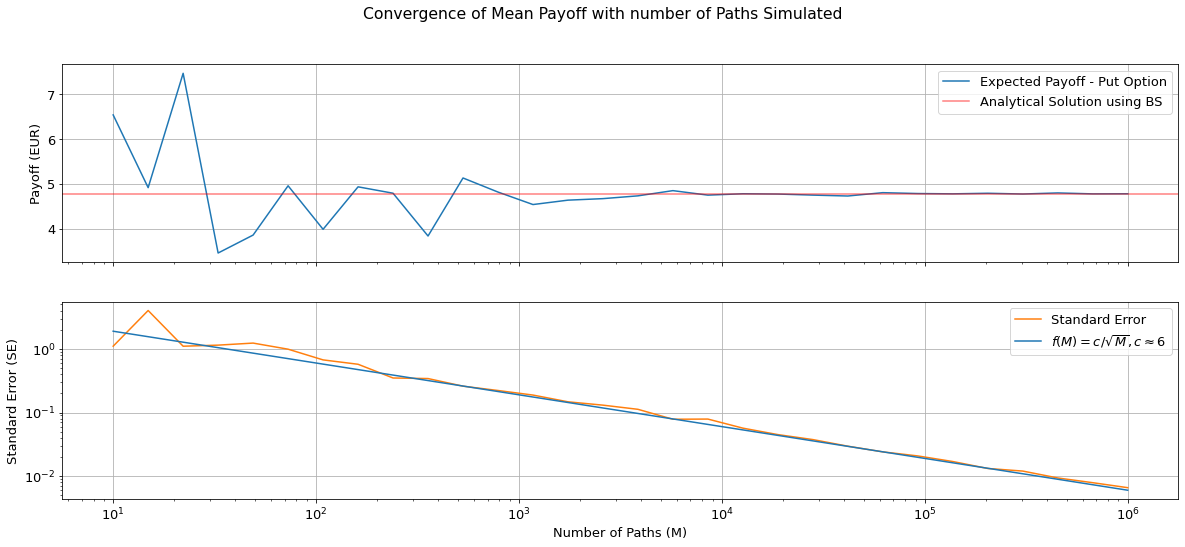

In [9]:
axs = results_convergence_df.plot(figsize=(20,8), grid=True, title='Convergence of Mean Payoff with number of Paths Simulated', subplots=True, logx=True)
axs[0].set_ylabel('Payoff (EUR)')
axs[0].axhline(4.778969051891707, color='r', linestyle='-', alpha=.5, label='Analytical Solution using BS') ;   axs[0].legend()

axs[1].plot(M_values, [ 6/np.sqrt(_m_value)  for _m_value in M_values], label=r'$f(M) = c/\sqrt{M}, c \approx 6$')    ;   axs[1].legend()

axs[1].set_yscale('log')
axs[1].set_ylabel('Standard Error (SE)')

## Different MC Implementation Approaches
> Vanilla MC - 100,000 samples
Mean = 4.757270
Standard Error = 0.025220

> Bootstrapping Results with and without Antithetic (AT) VR - with 100,000 samples and sqrt(samples) df
------ Without AT ------
Mean = 4.7845864899592705
Standard Error = 0.026560446487301444
------ With AT ------
Mean = 4.764542084945663
Standard Error = 0.020000435977867624

----------------------------------------------------------------------------------------------------------------------------------------------------------------
## Strike Price Graph

In [9]:
M = 100_000 ;   size_of_graph = 40 ;   start_x = 1  ;   end_x = 200

K_values = np.linspace(start_x, end_x, size_of_graph, dtype=int)

""" Creates a DataFrame to fill with values """
results_k_df = pd.DataFrame(np.zeros((size_of_graph, 3)), index=K_values , columns=['Expected Payoff - Put Option', 'Standard Error (SE)', 'Relative Standard Error (RSE)'])
results_k_df.index.name = 'Strike Price (EUR)'

for K in tqdm(K_values):
    _m, _se = bootstrapping(M, K=K)
    results_k_df.loc[K] = (_m, _se, _se/_m *100.) if _m!= 0 else np.nan

results_k_df

100%|██████████| 40/40 [12:00<00:00, 18.00s/it]


,Expected Payoff - Put Option,Standard Error (SE),Relative Standard Error (RSE)
Strike Price (EUR),,,
1,NaN,NaN,NaN
6,NaN,NaN,NaN
11,NaN,NaN,NaN
16,NaN,NaN,NaN
21,NaN,NaN,NaN
26,NaN,NaN,NaN
31,NaN,NaN,NaN
36,NaN,NaN,NaN
41,NaN,NaN,NaN


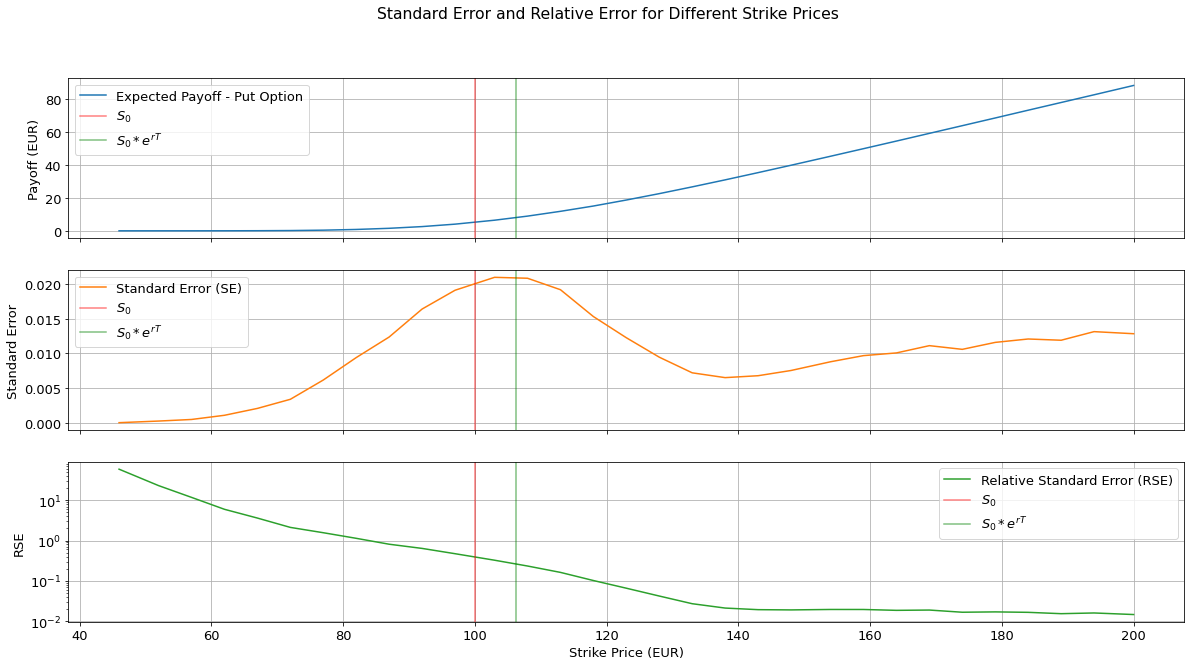

In [10]:
axs = results_k_df.plot(figsize=(20,10), grid=True, title='Standard Error and Relative Error for Different Strike Prices', subplots=True)
axs[0].set_ylabel('Payoff (EUR)')   ;   axs[1].set_ylabel('Standard Error')   ;   axs[2].set_ylabel('RSE')
axs[2].set_yscale('log')

axs[0].axvline(100, color='r', linestyle='-', alpha=.5, label=r'$S_0$')
axs[0].axvline(100*np.exp(.06), color='g', linestyle='-', alpha=.5, label=r'$S_0*e^{rT}$') ;   axs[0].legend()
axs[1].axvline(100, color='r', linestyle='-', alpha=.5, label=r'$S_0$')
axs[1].axvline(100*np.exp(.06), color='g', linestyle='-', alpha=.5, label=r'$S_0*e^{rT}$') ;   axs[1].legend()
axs[2].axvline(100, color='r', linestyle='-', alpha=.5, label=r'$S_0$')
axs[2].axvline(100*np.exp(.06), color='g', linestyle='-', alpha=.5, label=r'$S_0*e^{rT}$') ;   axs[2].legend()

plt.legend()

----------------------------------------------------------------------------------------------------------------------------------------------------------------
## Volatility Graph

In [11]:
M = 100_000 ;   size_of_graph = 40 ;   start_v = .01  ;   end_v = 10

V_values = np.logspace(np.log10(start_v), np.log10(end_v), size_of_graph)

""" Creates a DataFrame to fill with values """
results_V_df = pd.DataFrame(np.zeros((size_of_graph, 3)), index=np.log10(V_values) , columns=['Expected Payoff - Put Option', 'Standard Error (SE)', 'Relative Standard Error (RSE)'])
results_V_df.index.name = 'Realized Volatility (σ)'

for V in tqdm(V_values):
    _m, _se = bootstrapping(M, sigma=V)
    results_V_df.loc[np.log10(V)] = (_m, _se, _se/_m *100) #  if _m > 0 else 0

results_V_df

  0%|          | 0/40 [00:00<?, ?it/s]/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_42158/3215637781.py:11: RuntimeWarning: invalid value encountered in double_scalars
  results_V_df.loc[np.log10(V)] = (_m, _se, _se/_m *100) #  if _m > 0 else 0
100%|██████████| 40/40 [11:49<00:00, 17.74s/it]


,Expected Payoff - Put Option,Standard Error (SE),Relative Standard Error (RSE)
Realized Volatility (σ),,,
-2.000000,0.000000,0.000000,NaN
-1.923077,0.000000,0.000000,NaN
-1.846154,0.000000,0.000000,NaN
-1.769231,0.000011,0.000007,60.304078
-1.692308,0.000121,0.000032,26.818993
-1.615385,0.001439,0.000130,9.019999
-1.538462,0.006676,0.000317,4.750599
-1.461538,0.026055,0.000708,2.719128
-1.384615,0.073583,0.001347,1.830081


([<matplotlib.axis.XTick at 0x12eda4520>,
 [Text(-2.0, 0, '0.01'),
  Text(-1.5, 0, '0.03'),
  Text(-1.0, 0, '0.10'),
  Text(-0.5, 0, '0.32'),
  Text(0.0, 0, '1.00'),
  Text(0.5, 0, '3.16'),
  Text(1.0, 0, '10.00')])

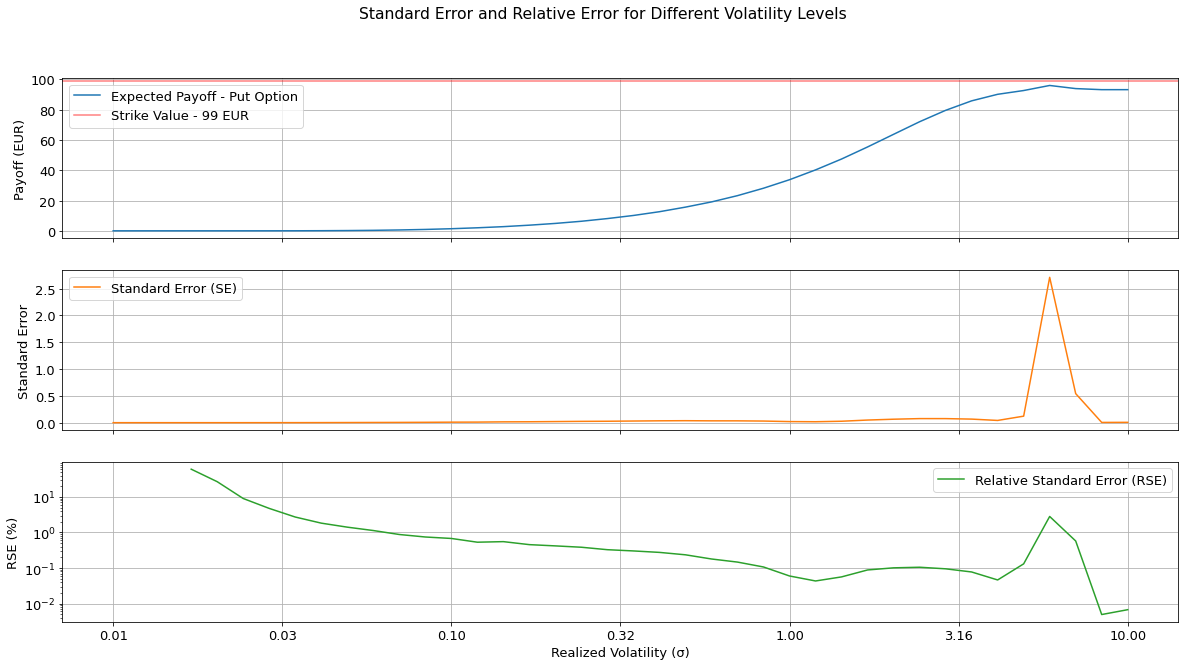

In [12]:
axs = results_V_df.plot(figsize=(20,10), grid=True, title='Standard Error and Relative Error for Different Volatility Levels', subplots=True) #, xticks=V_values)
axs[0].set_ylabel('Payoff (EUR)')   ;   axs[1].set_ylabel('Standard Error')   ;   axs[2].set_ylabel('RSE (%)')
axs[2].set_yscale('log')
axs[0].axhline(99, color='r', linestyle='-', alpha=.5, label='Strike Value - 99 EUR') ;   axs[0].legend()

plt.xticks(plt.xticks()[0][1:-1], [f'{10**x:.2f}' for x in plt.xticks()[0][1:-1]])

## 3D Plot - Strike Price / Volatility

In [101]:
import multiprocessing
from joblib import Parallel, delayed

""" Simulation Parameters """
M = 10_000    ;    total_points = 900  ;    print(f'Total Paths Calculated (M) = {M*total_points}')# points should be [2500, 900]

start_sigma = 0.01  ;   end_sigma = 20
start_K = 1  ;   end_K = 200

""" Prepare Input """
size_of_graph = np.sqrt(total_points).astype(int)   # points should be [2500, 900]
V_values = np.logspace(np.log10(start_sigma), np.log10(end_sigma), size_of_graph, base=10)
# V_values = np.linspace(start_sigma, end_sigma, size_of_graph)
K_values = np.linspace(start_K, end_K, size_of_graph, dtype=int)

input_matrix = np.empty((0, 2))
for sigma in V_values:
    for K in K_values:
        input_matrix = np.append(input_matrix, np.array([[sigma, K]]), axis=0)

inputs = tqdm(input_matrix)


""" Define function that calculates """
def simulate(input_matrix):
    """ X """
    # x = np.log10(input_matrix[0])
    """ Y """
    # y = input_matrix[1]
    """ Z """
    _m, _se = bootstrapping(M, sigma=input_matrix[0], K=input_matrix[1])
    _r = (_se  /_m *100) if _m!= 0 else 0
    return np.array([np.log10(input_matrix[0]), input_matrix[1], _r])


""" Run Parallel Simulation """
num_cores = multiprocessing.cpu_count()
temp_output = Parallel(n_jobs=num_cores)(delayed(simulate)(row) for row in inputs)
""" Revert back to matrix form"""
# print(temp_output)
result_3D = np.empty((0, 3))
for array in temp_output:
    result_3D = np.append(result_3D, [array], axis=0)

Total Paths Calculated (M) = 9000000


100%|██████████| 900/900 [06:57<00:00,  2.15it/s]


/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_43792/3597477947.py:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot_trisurf(result_3D[:, 0], result_3D[:, 1], np.log10(result_3D[:, 2]), cmap=cm.jet, linewidth=0.2)


Text(0.5, 0.92, 'RSE for Different Strike Price and Volatility Levels')

/Users/alexanderithakis/miniforge3/envs/QF/lib/python3.10/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


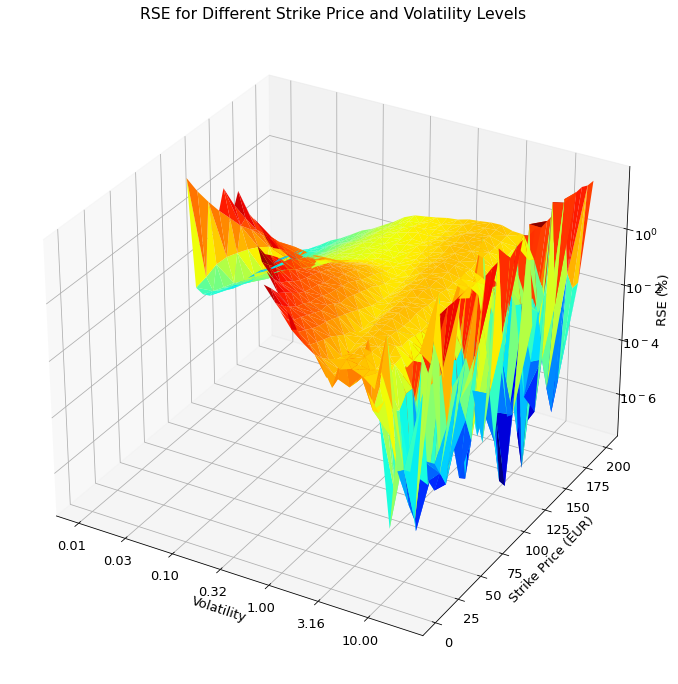

In [102]:
import matplotlib.ticker as mticker
from matplotlib import cm
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')
ax.plot_trisurf(result_3D[:, 0], result_3D[:, 1], np.log10(result_3D[:, 2]), cmap=cm.jet, linewidth=0.2)

def log_tick_formatter(val, pos=None):
    return r"$10^{:.0f}$".format(val)

ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))

plt.xticks(plt.xticks()[0][1:-1], [f'{10**x:.2f}' for x in plt.xticks()[0][1:-1]])

ax.set_ylabel('Strike Price (EUR)')   ;   ax.set_xlabel('Volatility')   ;   ax.set_zlabel('RSE (%)')
ax.set_title("RSE for Different Strike Price and Volatility Levels")

__________________________________________________________________________________________________________________________________________________________________________
# Part 2
## Question 1

In [85]:
""" Bootstrapping Technique """
def option_evaluation_MC(M, K = 99, sigma = 0.2, calc_delta=True, seed=None):
    def _gbm_euler(S0, r, sigma, T, M, zm):
        dt = T / M
        Sm = np.zeros((M+1, 2), dtype=float)   ;   Sm[0, 0] = S0
        for m in range(1, M+1):
            Sm[m, 0] = Sm[m-1, 0] + r*Sm[m-1, 0]*dt + sigma*Sm[m-1, 0]*sqrt(dt)*zm[m-1]
            Sm[m, 1] = m * dt
        return Sm[-1,0]

    epsilon = 0.001

    r = 0.06
    T = 1.
    N = 254

    # K = 99

    M = np.sqrt(M).astype(int)   ;   bootstrap_trials = M

    """ Create the Random Variables """
    np.random.seed(seed=seed)
    zm = np.random.normal(loc=0., scale=1, size=(N, ceil(M/2), bootstrap_trials))
    zm = np.concatenate((zm, -zm[:,:floor(M/2)]), axis=1)  ;  """ Antithetic Variable """

    _results = - np.ones((M, bootstrap_trials))
    for b_trial in range(bootstrap_trials):
        for _inx in range(M):
            _results[_inx, b_trial] = max(K- _gbm_euler(S0, r, sigma, T, N, zm[:, _inx, b_trial]), 0) * np.exp(-r*T)

    """ Create the Random Variables """
    np.random.seed(seed=seed)
    zm = np.random.normal(loc=0., scale=1, size=(N, ceil(M/2), bootstrap_trials))
    zm = np.concatenate((zm, -zm[:,:floor(M/2)]), axis=1)  ;  """ Antithetic Variable """
    if calc_delta:
        _results_2 = - np.ones((M, bootstrap_trials))
        for b_trial in range(bootstrap_trials):
            for _inx in range(M):
                _results_2[_inx, b_trial] = max(K- _gbm_euler(S0+epsilon, r, sigma, T, N, zm[:, _inx, b_trial]), 0) * np.exp(-r*T)
        delta =
        return np.mean(_results, axis=0).mean(), np.mean(_results, axis=0).std() / np.sqrt(_results.shape[1]), delta / epsilon

    return np.mean(_results, axis=0).mean(), np.mean(_results, axis=0).std() / np.sqrt(_results.shape[1])


In [130]:
M_values = 10**np.array([2, 3, 4, 5])
S0 = 100
epsilon= 0.1

""" Random Seed """
results_no_seed = np.empty((0,3))
for M in tqdm(M_values):
    results_no_seed = np.append(results_no_seed, np.array([option_evaluation_MC(M, K = 99, sigma = 0.2, calc_delta=True, seed=None)]), axis=0)
results_no_seed = np.concatenate((M_values.reshape(M_values.shape[0], 1), results_no_seed), axis=1)

""" Fixed Seed """
results_with_seed = np.empty((0,3))
for M in tqdm(M_values):
    results_with_seed = np.append(results_with_seed, np.array([option_evaluation_MC(M, K = 99, sigma = 0.2, calc_delta=True, seed=21)]), axis=0)
results_with_seed = np.concatenate((M_values.reshape(M_values.shape[0], 1), results_with_seed), axis=1)

100%|██████████| 4/4 [00:46<00:00, 11.55s/it]


In [131]:
""" Analytical Results
Option Value with Black-Scholes Formula = 4.778969051891707
Delta Value with Black-Scholes Formula = -0.3262644882651039
"""
V_analytical = 4.778969051891707    ;   D_Analytical = -0.3262644882651039

results_no_seed_df = pd.DataFrame(results_no_seed, columns=['M', 'E[Payoff of Put Option]', 'Standard Error', 'Delta']).set_index('M')
results_no_seed_df.insert(1, "Difference in Payoff with BS", results_no_seed_df[['E[Payoff of Put Option]']].to_numpy()- V_analytical)
results_no_seed_df.insert(4, "Difference in Delta with BS", results_no_seed_df[['Delta']].to_numpy()- D_Analytical)
results_no_seed_df

,E[Payoff of Put Option],Difference in Payoff with BS,Standard Error,Delta,Difference in Delta with BS
M,,,,,
100.0,5.524627,0.745658,0.281233,469.945073,470.271338
1000.0,4.683002,-0.095967,0.226101,84.355683,84.681947
10000.0,4.739412,-0.039557,0.056204,9.711023,10.037287
100000.0,4.807209,0.028240,0.020689,-17.331446,-17.005182


In [132]:
results_with_seed = pd.DataFrame(results_with_seed, columns=['M', 'E[Payoff of Put Option]', 'Standard Error', 'Delta']).set_index('M')
results_with_seed.insert(1, "Difference in Payoff with BS", results_with_seed[['E[Payoff of Put Option]']].to_numpy()- V_analytical)
results_with_seed.insert(4, "Difference in Delta with BS", results_with_seed[['Delta']].to_numpy()- D_Analytical)
results_with_seed

,E[Payoff of Put Option],Difference in Payoff with BS,Standard Error,Delta,Difference in Delta with BS
M,,,,,
100.0,3.735218,-1.043751,0.489956,-0.335587,-0.009322
1000.0,4.479403,-0.299566,0.196551,-0.320965,0.005299
10000.0,4.848506,0.069537,0.058999,-0.327064,-0.000800
100000.0,4.808095,0.029126,0.020162,-0.325553,0.000712


________________________________________________________________________________________________________________________________________________________________________
## Question 2 - Digital Option

In [204]:
def digital_option_MC(M, K = 99, sigma = 0.2, calc_delta=True, seed=None):
    def _gbm_euler(S0, r, sigma, T, M, zm):
        dt = T / M
        Sm = np.zeros((M+1, 2), dtype=float)   ;   Sm[0, 0] = S0
        for m in range(1, M+1):
            Sm[m, 0] = Sm[m-1, 0] + r*Sm[m-1, 0]*dt + sigma*Sm[m-1, 0]*sqrt(dt)*zm[m-1]
            Sm[m, 1] = m * dt
        return Sm[-1,0]

    epsilon = 0.001

    r = 0.06
    T = 1.
    N = 254

    # K = 99

    M = np.sqrt(M).astype(int)   ;   bootstrap_trials = M

    """ Create the Random Variables """
    np.random.seed(seed=seed)
    zm = np.random.normal(loc=0., scale=1, size=(N, ceil(M/2), bootstrap_trials))
    zm = np.concatenate((zm, -zm[:,:floor(M/2)]), axis=1)  ;  """ Antithetic Variable """

    _results = - np.ones((M, bootstrap_trials))
    for b_trial in range(bootstrap_trials):
        for _inx in range(M):
            # _results[_inx, b_trial] = max(K- _gbm_euler(S0, r, sigma, T, N, zm[:, _inx, b_trial]), 0) * np.exp(-r*T)
            # _results[_inx, b_trial] = 1 if _gbm_euler(S0, r, sigma, T, N, zm[:, _inx, b_trial]) > K else 0
            x = _gbm_euler(S0, r, sigma, T, N, zm[:, _inx, b_trial]) - K
            _results[_inx, b_trial] = 1 / (1 + np.exp(-100*x))

    """ Create the Random Variables """
    np.random.seed(seed=seed)
    zm = np.random.normal(loc=0., scale=1, size=(N, ceil(M/2), bootstrap_trials))
    zm = np.concatenate((zm, -zm[:,:floor(M/2)]), axis=1)  ;  """ Antithetic Variable """
    if calc_delta:
        _results_2 = - np.ones((M, bootstrap_trials))
        for b_trial in range(bootstrap_trials):
            for _inx in range(M):
                # _results_2[_inx, b_trial] = max(K- _gbm_euler(S0+epsilon, r, sigma, T, N, zm[:, _inx, b_trial]), 0) * np.exp(-r*T)
                # _results_2[_inx, b_trial] = 1*np.exp(-r*T) if _gbm_euler(S0, r, sigma, T, N, zm[:, _inx, b_trial]) > K else 0
                x = _gbm_euler(S0+epsilon, r, sigma, T, N, zm[:, _inx, b_trial]) - K
                _results[_inx, b_trial] = 1 / (1 + np.exp(-100*x))
        delta = np.mean(_results_2, axis=0).mean() - np.mean(_results, axis=0).mean()
        return np.mean(_results, axis=0).mean(), np.mean(_results, axis=0).std() / np.sqrt(_results.shape[1]), delta / epsilon

    return np.mean(_results, axis=0).mean(), np.mean(_results, axis=0).std() / np.sqrt(_results.shape[1])

In [205]:
M_values = 10**np.array([2, 3, 4])

""" Random Seed """
results_no_seed = np.empty((0,3))
for M in tqdm(M_values):
    results_no_seed = np.append(results_no_seed, np.array([digital_option_MC(M, K = 99, sigma = 2, calc_delta=True, seed=None)]), axis=0)
results_no_seed = np.concatenate((M_values.reshape(M_values.shape[0], 1), results_no_seed), axis=1)

""" Fixed Seed """
results_with_seed = np.empty((0,3))
for M in tqdm(M_values):
    results_with_seed = np.append(results_with_seed, np.array([digital_option_MC(M, K = 99, sigma = 2, calc_delta=True, seed=21)]), axis=0)
results_with_seed = np.concatenate((M_values.reshape(M_values.shape[0], 1), results_with_seed), axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_43792/857941237.py:31: RuntimeWarning: overflow encountered in exp
  _results[_inx, b_trial] = 1 / (1 + np.exp(-100*x))
/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_43792/857941237.py:44: RuntimeWarning: overflow encountered in exp
  _results[_inx, b_trial] = 1 / (1 + np.exp(-100*x))
100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


In [206]:
results_no_seed_df = pd.DataFrame(results_no_seed, columns=['M', 'E[Payoff of Put Option]', 'Standard Error', 'Delta']).set_index('M')
results_no_seed_df

,E[Payoff of Put Option],Standard Error,Delta
M,,,
100.0,0.150000,0.032404,-1150.000000
1000.0,0.171959,0.008992,-1171.958763
10000.0,0.164200,0.003037,-1164.200388


In [207]:
results_with_seed_df = pd.DataFrame(results_with_seed, columns=['M', 'E[Payoff of Put Option]', 'Standard Error', 'Delta']).set_index('M')
results_with_seed_df

,E[Payoff of Put Option],Standard Error,Delta
M,,,
100.0,0.080000,0.027568,-1080.000000
1000.0,0.147763,0.008164,-1147.762986
10000.0,0.168100,0.003411,-1168.100350
